# **自然言語・可視化・分析ライブラリ**
表形式で整理されたアンケートの自由記述の分析を行うためのライブラリです。\
Word Cloud、nlplot（頻出ワードグラフや共起ネットワーク等の可視化や分析）、TF-IDF計算、word2vecによるワードのベクトル計算と可視化（PCAとt-SNE）を実行します。\
満足度データがある場合は、Word Cloudとword2vecの可視化は、満足度の高･低別に表示します。
***
- **表形式で整理されたアンケートの自由記述の分析を想定しています。コード操作を不要にするため、表形式は以下としてください。**
- **カラム名は1列目を userID、2列目を comment（自由記述）、3列目を cs（満足度）としてください。3列目はなくても構いません。**
- [**注意**] csvデータは文字コードを「UTF-8」としてください。

|userID|comment|cs|
|---|---|---|
|U001  |総合的には満足してますが、○○が細かく調整できたらもっと使いやすいと思います。|4  |
|U002  |○○ボタンが押しにくいです。|2  |
|U003  |特にありません。|3  |
|U004  |既存品と取付位置が合わないことがつらいです。|1  |

- 「ランタイム→すべてのセルを実行」し、しばらくすると[ファイル指定]がうながされますので、上記形式のcsvデータを指定してください。
前処理（改行, 空白等の処理）→形態素分析→各種視覚化は自動で行います。

# **ライブラリのインストール**

In [1]:
pip install nlplot

     |████████████████████████████████| 967 kB 4.3 MB/s 
     |████████████████████████████████| 25.3 MB 2.1 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
#日本語フォントをインストール
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 3s (2,684 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-18ubuntu1) ...
Selecting previously unselected package fonts-ip

In [3]:
#Mecabのインストール
!pip install mecab-python3==0.996.5

     |████████████████████████████████| 17.1 MB 457 kB/s 


In [4]:
#matplotlib日本語化
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 4.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=f2189c8989f4f4dffc566bf0d6b32f53c9ed6cb8747b1d62507c25b575ed3311
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [5]:
from pathlib import Path
import pandas as pd
import re
import MeCab
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# **ファイル & CS_High/Low_Level & ストップワード指定**
※CS_Level設定について
- **このレベル設定は、例えば6段階評価の場合、4以上を[満足]、3以下を[不満足]とする等のシキイの設定です。一部の可視化は、ここでの設定に沿った層別を行います。**

In [6]:
#@title csvファイル（UTF-8）を指定してください
from google.colab import files
#print('csvファイル(UTF-8）を指定してください')
uploaded = files.upload()


Saving CS_text.csv to CS_text.csv


In [7]:
#@title CS_High/Low設定（上：設定以上をCS高/下：設定以下をCS低） { run: "auto" }
CS_High_level_x_or_More = 4 #@param {type:"number"}
CS_Low__level_x_or_Less = 3 #@param {type:"number"}

In [8]:
#@title ストップワード設定
stop_words = ["し", "い", "ある", "おる", "せる", "ない", "いる", "する", "の", "よう", "なる", "それ", "そこ", "これ", "こう", "ため", "そう", "れる", "られる"]

# **モジュール構築**

In [9]:
#@title データフレーム格納＆欠損値削除
if len(uploaded.keys()) != 1:
    print("アップロードは１ファイルにのみ限ります")
else:
    target = list(uploaded.keys())[0]

df = pd.read_csv(target)

df.dropna(subset=['comment'], inplace=True)
df.head()

,userID,comment,cs
4,U0005,天井センサーの検知エリアをオプションのプリズムを使わなくても良い、より広範囲な製品があるとう...,5
6,U0007,比較的満足です。 低高さに設置して広範囲をｶﾊﾞｰ出来るｾﾝｻｰがあれば助かります。 W50...,5
9,U0010,上記のアンケート結果は光電センサについてです。 尚、弊社のシャッター製品では、御社の無目セ...,5
10,U0011,環境（雨・日差し・雪・汚れ等）に影響されず、赤外線式に負けない安価なセンサーをご提案願います。,4
14,U0015,特にありません。,6


In [10]:
#@title 形態素解析（一般名詞・動詞:基礎型・形容詞:基礎型）＆カンマ･スペース区切りをデータフレームに格納
#形態素解析（一般名詞・動詞・形容詞（動詞と形容詞は基礎型）を抽出対象とした）
#スペース区切り分かち書き
def mecab_analysis(text):

    t = MeCab.Tagger('-Ochasen')

    node = t.parseToNode(text)

    words = []
     
    while node:
        if node.surface != "":  # ヘッダとフッタを除外

            word_type = node.feature.split(',')[0]
            sub_type = node.feature.split(',')[1]
            features_ = node.feature.split(',')

            #品詞を選択
            if word_type in ["名詞"]: 
                if sub_type in ['一般']:
                    word = node.surface
                    words.append(word)

            #動詞、形容詞[基礎型]を抽出（名詞のみを抽出したい場合は以下コードを除く）
            elif word_type in ['動詞','形容詞'] and not (features_[6] in stop_words):
                words.append(features_[6])

        node = node.next

        if node is None:
            break

    return " ".join(words)

#カンマ区切り分かち書き
def mecab_analysis2(text):

    t = MeCab.Tagger('-Ochasen')

    node = t.parseToNode(text)

    words2 = []

    while(node):

        if node.surface != "":  # ヘッダとフッタを除外
            word_type = node.feature.split(',')[0]
            sub_type = node.feature.split(',')[1]
            features_ = node.feature.split(',')

            if word_type in ['名詞']:  # 名詞をリストに追加する
                if sub_type in ['一般']:
                    words2.append(node.surface)

            #動詞、形容詞[基礎型]を抽出（名詞のみを抽出したい場合は以下コードを除く）
            elif word_type in ['動詞','形容詞'] and not (features_[6] in stop_words):
                    words2.append(features_[6])

        node = node.next
        if node is None:
            break
    return words2

#形態素結果をリスト化し、データフレームdf1に結果を列追加する
df['words'] = df['comment'].apply(mecab_analysis)
df['words2'] = df['comment'].apply(mecab_analysis2)

#表示
df

,userID,comment,cs,words,words2
4,U0005,天井センサーの検知エリアをオプションのプリズムを使わなくても良い、より広範囲な製品があるとう...,5,天井 センサー エリア オプション プリズム 使う 良い 製品 うれしい,"[天井, センサー, エリア, オプション, プリズム, 使う, 良い, 製品, うれしい]"
6,U0007,比較的満足です。 低高さに設置して広範囲をｶﾊﾞｰ出来るｾﾝｻｰがあれば助かります。 W50...,5,高い 広範囲 ｶﾊﾞｰ 出来る ｾﾝｻｰ 助かる W ×H ｾﾝｻｰ ｶﾊﾞｰ 出来る,"[高い, 広範囲, ｶﾊﾞｰ, 出来る, ｾﾝｻｰ, 助かる, W, ×H, ｾﾝｻｰ, ｶ..."
9,U0010,上記のアンケート結果は光電センサについてです。 尚、弊社のシャッター製品では、御社の無目セ...,5,上記 アンケート 光 センサ 弊社 シャッター 製品 御社 目 センサ 現場 声 製品 含め...,"[上記, アンケート, 光, センサ, 弊社, シャッター, 製品, 御社, 目, センサ,..."
10,U0011,環境（雨・日差し・雪・汚れ等）に影響されず、赤外線式に負けない安価なセンサーをご提案願います。,4,環境 雨 日差し 雪 汚れ 赤外線 負ける センサー 願う,"[環境, 雨, 日差し, 雪, 汚れ, 赤外線, 負ける, センサー, 願う]"
14,U0015,特にありません。,6,,[]
...,...,...,...,...,...
298,U0299,特になし。,5,,[]
300,U0301,今のままで不満はありませんが、今後も期待しております。,5,不満,[不満]
301,U0302,いつも大変お世話になって下ります。 OA-215Vセンサーの誤作動が多いと感じます。特に感度...,4,下りる OA V センサー 誤る 多い 感じる 感度 高い ドア ウェイ 扉 近い 扉 繰り...,"[下りる, OA, V, センサー, 誤る, 多い, 感じる, 感度, 高い, ドア, ウェ..."
303,U0304,円型の天井タッチがあればいいです。,4,円型 いい,"[円型, いい]"


In [11]:
#@title 形態素結果を層別しデータフレームに格納
#全データをデータフレームに格納
all_words=' '.join(df['words'])
df_all = pd.Series(all_words)

#CSが高いuserの声（words）をデータフレームに格納
drop_index = df.index[df['cs'] <=CS_Low__level_x_or_Less]
#条件にマッチしたIndexを削除
df_high = df.drop(drop_index)
all_high_words=' '.join(df_high['words'])
df_all_high_words = pd.Series(all_high_words)

#CSが低いuserの声（words）をデータフレームに格納
drop_index2 = df.index[df['cs'] >=CS_High_level_x_or_More]
#条件にマッチしたIndexを削除
df_low = df.drop(drop_index2)
all_low_words=' '.join(df_low['words'])
df_all_low_words = pd.Series(all_low_words)

print('CS高ユーザーの声(Words）：')
print(df_all_high_words)
print('CS低ユーザーの声(Words）：')
print(df_all_low_words)

CS高ユーザーの声(Words）：
0    天井 センサー エリア オプション プリズム 使う 良い 製品 うれしい 高い 広範囲 ｶﾊ...
dtype: object
CS低ユーザーの声(Words）：
0    ビルトイン 互換 ビルトイン がれ ビーム ヘット 部分 出来る 芯 コネクター できる フ...
dtype: object


In [12]:
#@title ワード出現回数カウント（表示する場合は#外す）
#カンマ区切り分かち書きしたワードをリスト化
words_list = df.words2.tolist()
words_list = sum(words_list,[])

from collections import Counter

#出現回数を集計し、最頻順にソートし、resultに格納
words_count = Counter(words_list)
result = words_count.most_common()

#出現回数結果を画面に出力
#for word, cnt in result:
#    print(word, cnt)

# **nlplot**
「nlplot」は、自然言語の可視化・分析できるライブラリです。
- N-gram bar chart, N-gram tree Map, Histogram of the word count, wordcloud, co-occurrence networks（共起ネットワーク）, sunburst chart（サンバースト）

In [13]:
#@title uni-gram表示
import nlplot

npt = nlplot.NLPlot(df, target_col='words')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
#stopwords = npt.get_stopword(top_n=0, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
#    stopwords=stopwords,
)

100%|██████████| 141/141 [00:00<00:00, 14117.85it/s]


In [14]:
#@title tree map表示
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
#    stopwords=stopwords,
)

100%|██████████| 141/141 [00:00<00:00, 61571.77it/s]


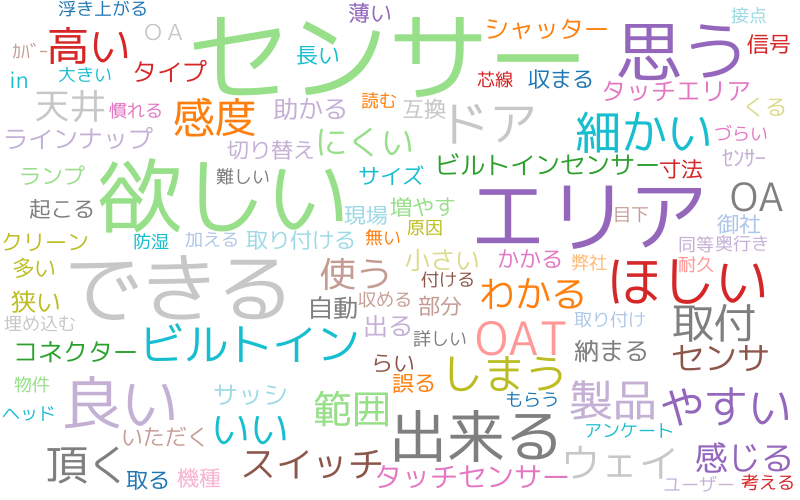

In [15]:
#@title Word Cloud表示（nlpot）
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
#    stopwords=stopwords,
)

In [16]:
#@title Word Distribution表示（単語数の分布）
# 単語数の分布
npt.word_distribution(
    title='number of words distribution',
    xaxis_label='count',
)

In [17]:
#@title Build Graph（共起ネットワーク）表示
# ビルド（データ件数によっては処理に時間を要します）※ノードの数のみ変更
npt.build_graph(min_edge_frequency=1,
                #stopwords=stopwords,
                )

display(
    npt.node_df.head(), npt.node_df.shape,
    npt.edge_df.head(), npt.edge_df.shape
)

npt.co_network(
    title='Co-occurrence network',
)

node_size:99, edge_size:298


,id,id_code,adjacency_frequency,betweeness_centrality,clustering_coefficient,community
0,誤る,0,2,0.000000,1.000000,2
1,いただける,1,2,0.000000,1.000000,0
2,防,2,2,0.000000,1.000000,2
3,感じる,3,7,0.000177,0.809524,3
4,多い,4,2,0.000000,1.000000,2


(99, 6)

,source,target,edge_frequency,source_code,target_code
0,センサー,欲しい,13,69,9
1,できる,エリア,10,24,31
2,エリア,細かい,8,31,67
3,V,エリア,8,48,31
4,できる,センサー,8,24,69


(298, 5)

In [18]:
#@title Sunburst表示
npt.sunburst(
    title='All sentiment sunburst chart',
    colorscale=True,
    color_continuous_scale='Oryel',
    width=800,
    height=600,
    #save=True
)

# **Word Cloud**
- ワードクラウドは、文章中で出現頻度が高い語を複数選び出し、その頻度に応じた大きさで図示する手法。
- 表示するワードクラウドは全4種。①ワード出現回数ベース／②TF-IDFベース（全データ）/③TF-IDFベース（CS高データ）/④TF-IDFベース（CS低データ）\
※語の表示数はmax_words, Word Cloudの表示サイズはwidth, heightで設定できる

## **TF-IDF**
- TF-IDF は ワードの出現頻度とレア度が考慮された指標

\begin{eqnarray} TF(d,w) &=& \frac{文書d における語wの出現回数}{文書d における全語の出現回数の和}\\ IDF(w) &=& log(\frac{全文書数}{語w を含む文書数})\\ TFIDF(d,w) &=& TF(d,w) \times IDF(w) \end{eqnarray}


In [19]:
#@title TF-IDFマトリクス作成＆データフレーム格納
# ライブラリインポート
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDFのベクトル処理
vectorizer = TfidfVectorizer(use_idf=True)
tfidf = vectorizer.fit_transform(df['words'] )

# TF-IDF値を「センテンス×ワード」マトリクスをデータフレーム化
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names(), index=df['words'])
#display(df_tfidf)

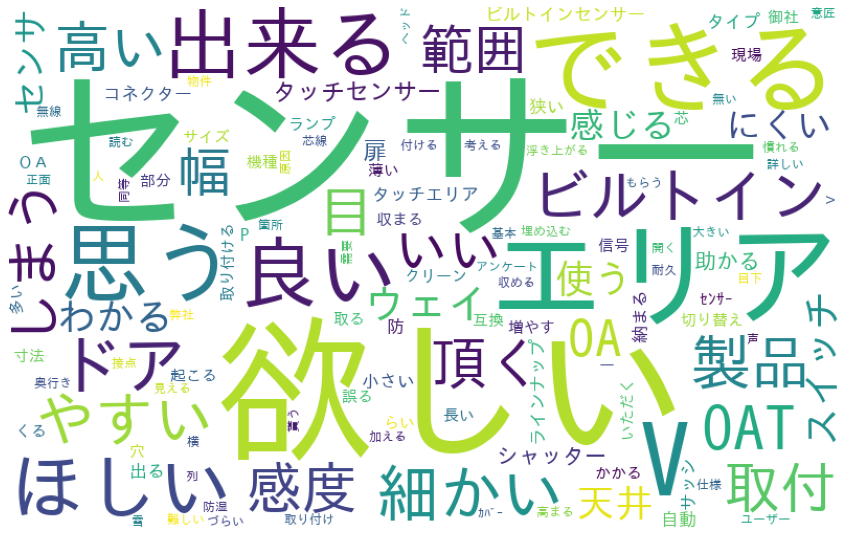

In [46]:
#@title Word Cloud by word_count（All Data）：🔲型 → #maskの#外すと🍩型に

#wordcloud取込用にresultを辞書型ヘ変換
dic_result = dict(result)

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
from wordcloud import WordCloud

#画像データダウンロード（biwakoの画像リンクもあり。変更する場合は#調整）
import requests

url = "https://github.com/hima2b4/Word-Cloud/raw/main/donuts.png"
#url = "https://github.com/hima2b4/Word-Cloud/raw/main/biwa.png"

file_name = "donuts.png"
#file_name = "biwa.png"

response = requests.get(url)
image = response.content

with open(file_name, "wb") as f:
    f.write(image)

#ライブラリインポート
from PIL import Image
import numpy as np

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
custom_mask = np.array(Image.open('donuts.png'))
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      #mask=custom_mask,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=800,
                      height=500,
                      ).fit_words(dic_result)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

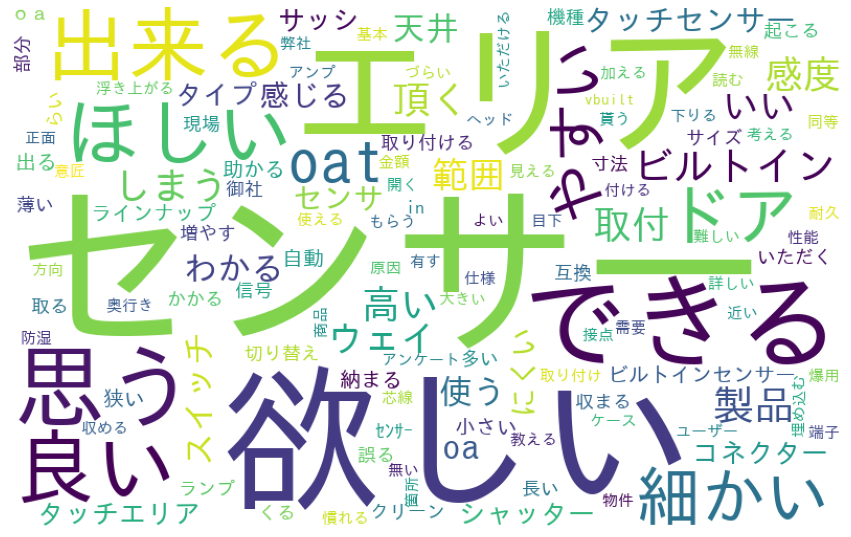

In [47]:
#@title Word Cloud with TF-IDF（All DATA)：🔲型 → #maskの#外すと🍩型に
# TF-IDF計算
tfidf_vec2 = vectorizer.fit_transform(df_all).toarray()[0]
# TF-IDFを辞書化
tfidf_dict2 = dict(zip(vectorizer.get_feature_names(), tfidf_vec2))
# 値が正のkeyだけ残す
tfidf_dict2 = {k: v for k, v in tfidf_dict2.items() if v > 0}

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      #mask=custom_mask,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=800,
                      height=500,
                      ).generate_from_frequencies(tfidf_dict2)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

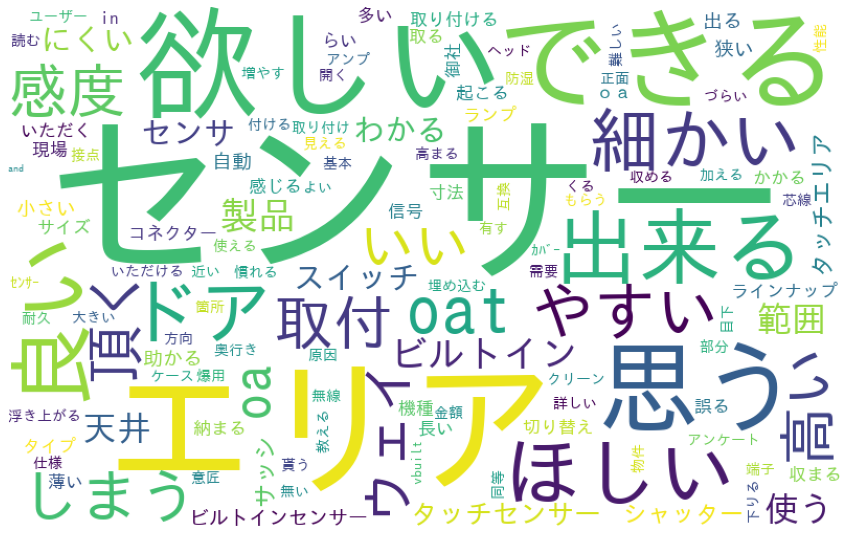

In [48]:
#@title Word Cloud with High CS Data (TF-IDF)：🔲型 → #maskの#外すと🍩型に
tfidf_vec = vectorizer.fit_transform(df_all_high_words).toarray()[0]
# TF-IDFを辞書化
tfidf_dict = dict(zip(vectorizer.get_feature_names(), tfidf_vec))
# 値が正のkeyだけ残す
tfidf_dict = {k: v for k, v in tfidf_dict.items() if v > 0}

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      #mask=custom_mask,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=800,
                      height=500,
                      ).generate_from_frequencies(tfidf_dict)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

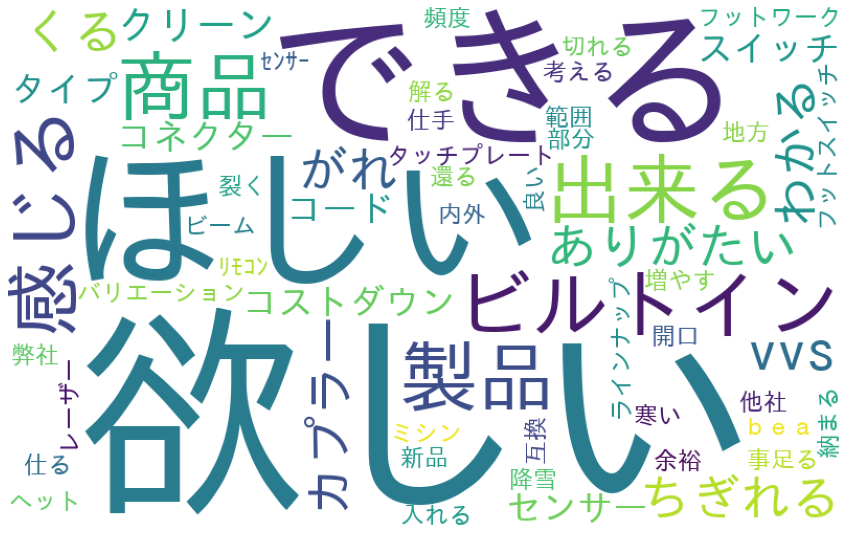

In [49]:
#@title Word Cloud with Low CS Data (TF-IDF)：🔲型 → #maskの#外すと🍩型に
tfidf_vec = vectorizer.fit_transform(df_all_low_words).toarray()[0]
# TF-IDFを辞書化
tfidf_dict = dict(zip(vectorizer.get_feature_names(), tfidf_vec))
# 値が正のkeyだけ残す
tfidf_dict = {k: v for k, v in tfidf_dict.items() if v > 0}

#Word Cloudで画像生成（#max_words, width, heightは任意設定）
wordcloud = WordCloud(background_color='white',
                      max_words=125,
                      #mask=custom_mask,
                      font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                      width=800,
                      height=500,
                      ).generate_from_frequencies(tfidf_dict)

#生成した画像の表示
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **Visualization of word2vec**

In [24]:
#@title Word2Vecモジュール（語の最小出現数やベクトル生成手法等の設定）
from gensim.models import word2vec

# size : 中間層のニューロン数・数値に応じて配列の大きさが変わる。数値が多いほど精度が良くなりやすいが、処理が重くなる。
# min_count : この値以下の出現回数の単語を無視
# window : 対象単語を中心とした前後の単語数
# iter : epochs数
# sg : skip-gramを使うかどうか 0:CBOW 1:skip-gram

model = word2vec.Word2Vec(df['words2'],
                          size=200,
                          min_count=5,
                          window=5,
                          iter=20,
                          sg = 1)    # sg=1:skip-gram使用

model2 = word2vec.Word2Vec(df_high['words2'],
                          size=200,
                          min_count=5,
                          window=5,
                          iter=20,
                          sg = 1)    # sg=1:skip-gram使用

model3 = word2vec.Word2Vec(df_low['words2'],
                          size=200,
                          min_count=2,
                          window=5,
                          iter=20,
                          sg = 1)    # sg=1:skip-gram使用
#学習結果
#print(model.wv.vectors.shape)  # 分散表現の形状
#print(model.wv.vectors)  #分散表現の配列

In [25]:
#@title ベクトル化した各語彙確認
#ベクトル化したテキストの各語彙確認
model.wv.index2word

['センサー',
 '欲しい',
 'エリア',
 'できる',
 'V',
 '思う',
 '良い',
 '出来る',
 'ほしい',
 'ドア',
 '細かい',
 'OAT',
 '製品',
 'ビルトイン',
 'やすい',
 '高い',
 '目',
 '感度',
 '取付',
 'しまう',
 '頂く',
 'いい',
 '範囲',
 '幅',
 'OA',
 'ウェイ',
 '天井',
 '使う',
 'わかる',
 'スイッチ',
 'センサ',
 'にくい',
 '感じる',
 'タッチセンサー',
 '扉']

<Figure size 432x288 with 0 Axes>

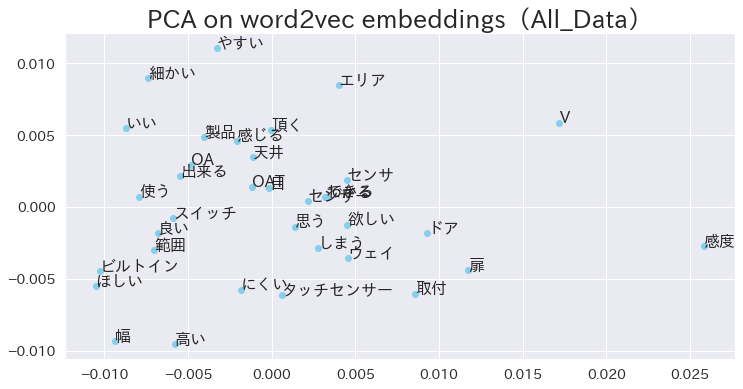

In [40]:
#@title PCA表示（ALL Data)
#PCA実行
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
values = pca.fit_transform(model.wv.vectors)
#print(values.shape)
#print(values)

#PCA可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(figsize=(12,6))
for value, word in zip(values, model.wv.index2word):
    plt.plot(value[0], value[1], marker='o',color='skyblue')
    plt.annotate(word, (value[0], value[1]))
    plt.title('PCA on word2vec embeddings（All_Data）', fontsize=25)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
plt.show()

<Figure size 432x288 with 0 Axes>

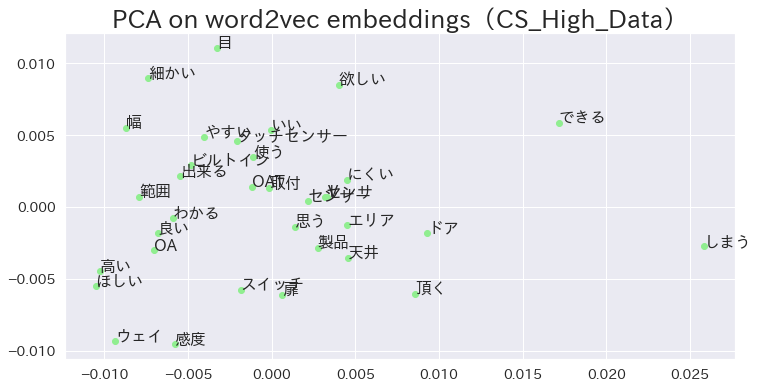

In [41]:
#@title PCA表示（CS_High Data)
pca = PCA(n_components=2)
values2 = pca.fit_transform(model2.wv.vectors)

#PCA可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(figsize=(12,6))
for value, word in zip(values, model2.wv.index2word):
    plt.plot(value[0], value[1], marker='o',color='lightgreen')
    plt.annotate(word, (value[0], value[1]))
    plt.title('PCA on word2vec embeddings（CS_High_Data）', fontsize=25)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
plt.show()

<Figure size 432x288 with 0 Axes>

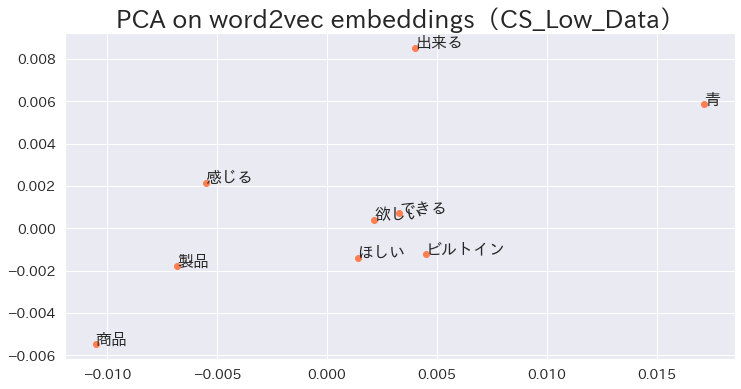

In [42]:
#@title PCA表示（CS_Low Data)
pca = PCA(n_components=2)
values3 = pca.fit_transform(model3.wv.vectors)

#PCA可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(figsize=(12,6))
for value, word in zip(values, model3.wv.index2word):
    plt.plot(value[0], value[1], marker='o',color='coral')
    plt.annotate(word, (value[0], value[1]))
    plt.title('PCA on word2vec embeddings（CS_Low_Data）', fontsize=25)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
plt.show()

<Figure size 432x288 with 0 Axes>

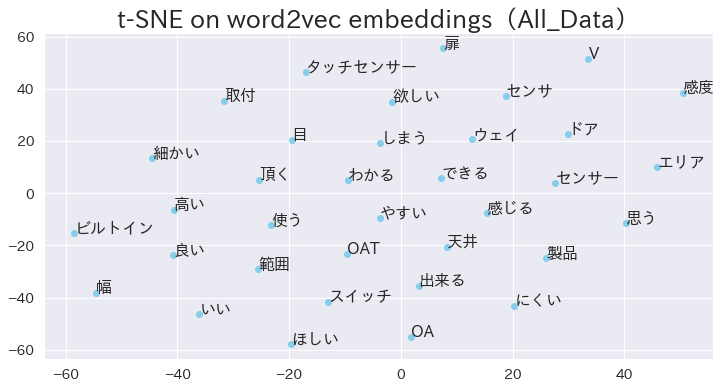

In [45]:
#@title t-SNE表示（All Data)
#t-SNE実行
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
values4 = tsne.fit_transform(model.wv.vectors)

#t-SNE可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(figsize=(12,6))
for value, word in zip(values4, model.wv.index2word):
    plt.plot(value[0], value[1], marker='o',color='skyblue')
    plt.annotate(word, (value[0], value[1]))
    plt.title('t-SNE on word2vec embeddings（All_Data）', fontsize=25)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
plt.show()

<Figure size 432x288 with 0 Axes>

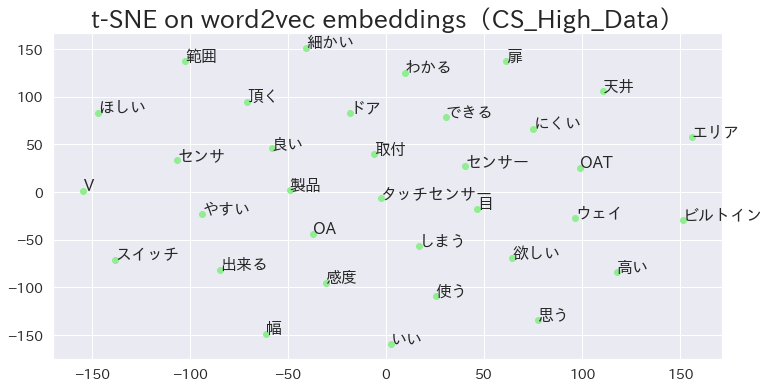

In [44]:
#@title t-SNE表示（CS_High Data)
#t-SNE実行
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
values5 = tsne.fit_transform(model2.wv.vectors)

#t-SNE可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(figsize=(12,6))
for value, word in zip(values5, model2.wv.index2word):
    plt.plot(value[0], value[1], marker='o',color='lightgreen')
    plt.annotate(word, (value[0], value[1]))
    plt.title('t-SNE on word2vec embeddings（CS_High_Data）', fontsize=25)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
plt.show()

<Figure size 432x288 with 0 Axes>

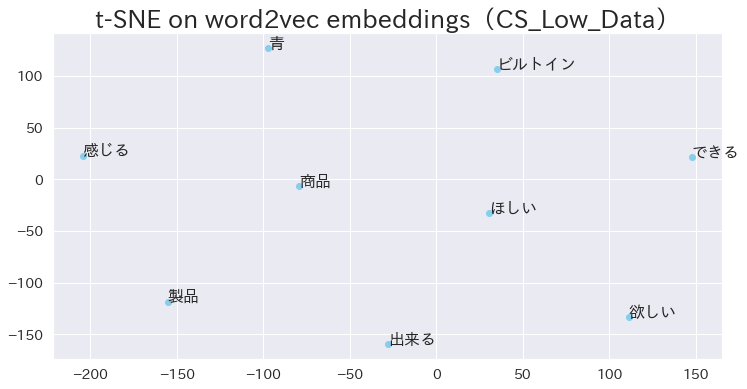

In [43]:
#@title t-SNE表示（CS_Low Data)
#t-SNE実行
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
values6 = tsne.fit_transform(model3.wv.vectors)

#t-SNE可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

sns.set(font="IPAexGothic")
plt.rcParams["font.size"] = 16
plt.tight_layout()
fig = plt.figure(figsize=(12,6))
for value, word in zip(values6, model3.wv.index2word):
    plt.plot(value[0], value[1], marker='o',color='skyblue')
    plt.annotate(word, (value[0], value[1]))
    plt.title('t-SNE on word2vec embeddings（CS_Low_Data）', fontsize=25)
    #plt.xlim(-0.02,0.04)
    #plt.ylim(-0.02,0.04)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
plt.show()

## **参考サイト**
- [**【データ分析実践】口コミを使ったキャンプ場に関する分析3 ~ Word2Vec編 ~**](https://data-analytics.fun/2020/03/12/word2vec/)

- [**Janomeで TF-IDF をやってみた**](https://zenn.dev/megane_otoko/articles/013_tf_idf_trial)

- [**ニュース記事をword2vecでベクトル化して可視化するレシピ**](https://axross-recipe.com/recipes/34)

- [**自然言語を簡単に可視化・分析できるライブラリ「nlplot」を公開**](https://www.takapy.work/entry/2020/05/17/192947)

- [**NLPLOTが凄い！自然言語を可視化・分析できるPYTHONライブラリ**](https://boxcode.jp/nlplot%E3%81%8C%E5%87%84%E3%81%84%EF%BC%81%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E3%82%92%E5%8F%AF%E8%A6%96%E5%8C%96%E3%83%BB%E5%88%86%E6%9E%90%E3%81%A7%E3%81%8D%E3%82%8Bpython%E3%83%A9%E3%82%A4)

- [**PYTHONで感情分析（形態素解析準備編）- MECAB**](https://boxcode.jp/python%e3%81%a7%e6%84%9f%e6%83%85%e5%88%86%e6%9e%90%ef%bc%88%e5%bd%a2%e6%85%8b%e7%b4%a0%e8%a7%a3%e6%9e%90%e6%ba%96%e5%82%99%e7%b7%a8%ef%bc%89-mecab)

- [**ポルカドットスティングレイの歌詞データをPythonで機械学習、分析してみた -word2vec‐**](https://www.cloudnotes.tech/entry/polka_word2vec)